In [1]:
# importacao de bibliotecas necessarias

# bibliotecas de redes neurais
import tensorflow as tf
from tensorflow import keras
from keras.utils.vis_utils import plot_model
import sklearn
from sklearn.model_selection import StratifiedKFold


# bibliotecas de manipulacao de variaveis de ambiente e acesso a diretorios
import os, warnings
import glob

# bibliotecas de manipulacao e visualizacao de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preparação dos Dados

Retomamos a mesma preparação dos dados abordada na [primeira entrega](https://github.com/GFerrazzo/INE5644/blob/main/Primeira%20Entrega%20-%20Trabalho%20Final.ipynb). Dessa vez, retiramos os blocos de código com propósito de visualização da preparação.

In [2]:
# df = pd.read_csv('https://raw.githubusercontent.com/GFerrazzo/INE5644/main/KaggleV2-May-2016.csv', sep = ',')

df = pd.read_csv('KaggleV2-May-2016.csv', sep = ',')

In [3]:
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

In [4]:
df['Gender'] = df['Gender'].map({'M' : 1, 'F' : 0})
df['No-show'] = df['No-show'].map({'Yes' : 1, 'No' : 0})

# esse bloco foi alterado para nao utilizarmos mais o dtype boolean. o Keras teve algum problema em trabalhar com esse dtype.

In [5]:
df['ScheduleToAppointment'] = (df['AppointmentDay'] - df['ScheduledDay']).astype('timedelta64[D]') + 1

In [6]:
df['ScheduleWeekDay'] = df['ScheduledDay'].dt.weekday

In [7]:
df.drop(columns=['PatientId','AppointmentID','ScheduledDay','AppointmentDay'], inplace=True)

In [8]:
df.drop(df[df['Age'] < 0].index, inplace=True)

In [9]:
df.drop(df[df['ScheduleToAppointment'] < 0].index, inplace=True)

In [10]:
df[df['No-show'] == True].shape[0]/df.shape[0]

0.2018982817745044

In [11]:
df.drop(columns=['Neighbourhood'], inplace=True)

In [12]:
# df['Age'] = pd.cut(df['Age'], bins=29, precision=0)

In [13]:
# df['Handcap'] = df['Handcap'].map({1 : True, 2 : True, 3 : True, 4 : True, 0 : False})

In [14]:
# df['ScheduleToAppointment'] = pd.cut(df['ScheduleToAppointment'], bins=30, precision=0)

In [15]:
df.sample(5)

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,ScheduleToAppointment,ScheduleWeekDay
104807,0,96,0,1,0,0,1,0,0,0.0,1
109146,1,35,0,0,0,0,0,0,0,4.0,0
23986,0,4,0,0,0,0,0,0,0,0.0,0
37583,1,56,0,1,0,0,0,0,0,0.0,2
99011,0,15,1,0,0,0,0,0,0,0.0,3


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110521 entries, 0 to 110526
Data columns (total 11 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Gender                 110521 non-null  int64  
 1   Age                    110521 non-null  int64  
 2   Scholarship            110521 non-null  int64  
 3   Hipertension           110521 non-null  int64  
 4   Diabetes               110521 non-null  int64  
 5   Alcoholism             110521 non-null  int64  
 6   Handcap                110521 non-null  int64  
 7   SMS_received           110521 non-null  int64  
 8   No-show                110521 non-null  int64  
 9   ScheduleToAppointment  110521 non-null  float64
 10  ScheduleWeekDay        110521 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 10.1 MB


In [ ]:
# df['Age'] = df['Age'].cat.codes
# df['ScheduleToAppointment'] = df['ScheduleToAppointment'].cat.codes

# Primeiro Modelo

In [ ]:
df_model = df.copy()

In [ ]:
target = df_model.pop('No-show')

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((df_model.values, target.values))

In [ ]:
train_dataset = dataset.shuffle(len(df_model)).batch(32)

Começaremos com um modelo bem simples. Composto apenas por três camadas.

In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

In [ ]:
model1.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [ ]:
model1_performance = model1.fit(train_dataset, epochs=5)

Como podemos notar, ao utilizar o dataset como ele foi fornecido, chegamos numa acurácia de 79.81%. 

Coincidentemente (veremos que não é coincidência), esse é o valor do balanço das nossas classes, como podemos ver:

In [ ]:
df[df['No-show'] == True].shape[0]/df.shape[0]

In [ ]:
df[df['No-show'] == False].shape[0]/df.shape[0]

Ou seja, podemos imaginar que nosso modelo está prevendo "Presença" para todas predições, mas só acerta 79.81% das vezes.
Podemos conferir isso com uma matriz de confusão.

In [ ]:
y_pred_model1 = model1.predict(df_model)

In [ ]:
tf.math.confusion_matrix(labels=target, predictions=y_pred_model1.ravel()>0.5)

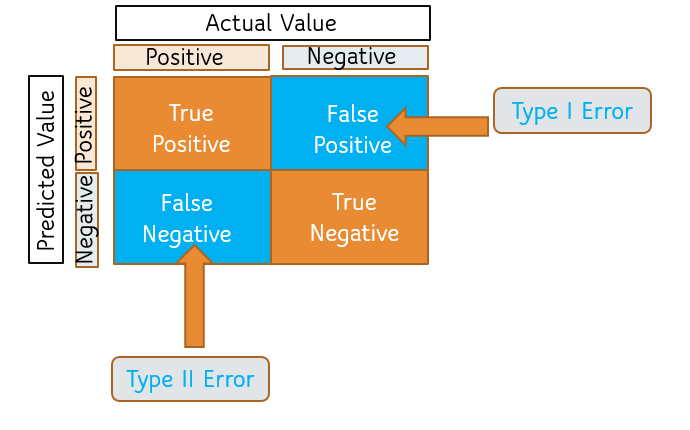

Comparando com a imagem acima (fonte), podemos notar que temos:
    88207 casos de positivos verdadeiros.
    22314 casos de falsos negativos.
    
Que nos dá a acurácia de 79.81%.

Indo além, podemos verificar pelo próprio resultado da predição, que retorna 110521 predições de "Falso":

In [ ]:
y_pred_model1.ravel()>0.5

In [ ]:
np.unique(y_pred_model1.ravel()>0.5, return_counts=True)

# Segundo Modelo

O que notamos que aconteceu no primeiro modelo é o chamado "paradoxo da acurácia", onde descobrimos que a acurácia não é um método "certeiro" de medir a previsibilidade do nosso modelo. Devemos alterar dois itens no nosso primeiro modelo:
- Consertar o desbalanço das classes
- Alterar a métrica de cálculo da previsibilidade do modelo

Para o primeiro item acima, temos várias opções: undersampling, oversampling, etc. Neste segundo modelo, vamos alterar as métricas para ver o impacto que a métrica errada tinha sobre o modelo, assim como realizar um oversampling da classe minoritária.

Temos inúmeras opções de métricas diferentes, citamos algumas, com suas nomenclaturas em inglês (para evitar traduções errôneas):
- Precision = TP/(TP+FP)
- Recall = TP/(TP+FN)
- F1 Score = 2 * Recall * Precision / (Recall + Precision)
- Area Under ROC Curve
- G-Measure = sqrt(Precision * Recall)
- Jaccard Index = TP/(TP+FP+FN)


onde 

TP = True Positive

FP = False Positive

FN = False Negative

In [ ]:
count_class_0, count_class_1 = df['No-show'].value_counts()
print(count_class_0, count_class_1)

In [ ]:
df_class_0 = df[df['No-show'] == 0]
df_class_1 = df[df['No-show'] == 1]

Undersampling

In [ ]:
df_class_0_resampled = df_class_0.sample(count_class_1)
df_undersampled = pd.concat([df_class_1, df_class_0_resampled])
df_undersampled['No-show'].value_counts()

Oversampling

In [ ]:
df_class_1_resampled = df_class_1.sample(count_class_0, replace=True)
df_oversampled = pd.concat([df_class_0, df_class_1_resampled])
df_oversampled['No-show'].value_counts()

In [ ]:
df_model = df_undersampled.copy()

target = df_model.pop('No-show')

dataset = tf.data.Dataset.from_tensor_slices((df_model.values, target.values))

train_dataset = dataset.shuffle(len(df_model)).batch(32)

model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
j
model2.compile(optimizer='sgd',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=[tf.keras.metrics.AUC()])

model2_performance = model2.fit(train_dataset, epochs=10)

In [ ]:

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', # qual metrica sera monitorada
                              factor=0.2, # fator de multiplicacao (no caso reducao) do learning rate
                              patience=2, # quantas epocas esperamos o "plateau"
                              min_lr=0.0001 # menor learning rate possivel
                                )

In [ ]:
df_model = df_oversampled.copy()

target = df_model.pop('No-show')

dataset = tf.data.Dataset.from_tensor_slices((df_model.values, target.values))

train_dataset = dataset.shuffle(len(df_model)).batch(32)

model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(11, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01) ,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                metrics=[tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC(),
                        tf.keras.metrics.Precision()])

model2_performance = model2.fit(train_dataset, callbacks=[reduce_lr], epochs=180)

In [ ]:
y_pred_model2 = model2.predict(df_model)
tf.math.confusion_matrix(labels=target, predictions=y_pred_model2.ravel()>0.5)

Pela matriz de confusão podemos perceber uma melhora na predição do modelo, porém ainda não temos resultados totalmente satisfatórios.

# Terceiro Modelo

Para esse modelo, vamos deixar para trás a utilização de redes neurais e utilizar um mobelo de gradient boosting.

In [17]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, accuracy_score, RocCurveDisplay

In [18]:
target = 'No-show'
feat_cols = [col for col in df.columns if col != target]

In [19]:
train_split = 70000

x = df.iloc[:train_split][feat_cols]
y = df.iloc[:train_split][target]

model_params = {
    "objective": 'binary',
    "max_depth": -1,
    "num_leaves": 9,
    "learning_rate": 0.1,
    "n_estimators": 100,
    "boosting_type": "rf",
    "min_data_in_leaf": 100,
    "bagging_freq": 4,
    "bagging_fraction": 0.7,
    "feature_fraction": 0.7,
    "colsample_bytree": 0.5,
#     "is_unbalance": True,
    "scale_pos_weight": 1.75,
    "metric": "auc"
}

model3 = lgb.LGBMRegressor(**model_params).fit(x, y)

test_df = (
    df
    .iloc[train_split:]
    .assign(pred = lambda df: pd.DataFrame(model3.predict(df[feat_cols])).values)
)

print(roc_auc_score(test_df[target], test_df['pred']))

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
0.7192204508319895


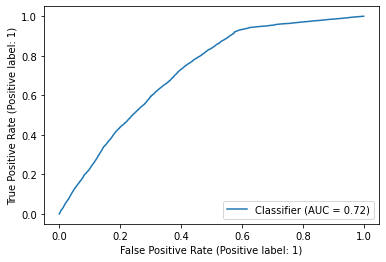

In [20]:
RocCurveDisplay.from_predictions(test_df[target], test_df['pred'])

<AxesSubplot:>

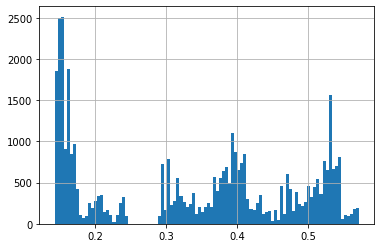

In [21]:
test_df['pred'].hist(bins=100)

In [45]:
y_pred_model3 = model3.predict(df[feat_cols])
matriz_confusao = tf.math.confusion_matrix(labels=df[target], predictions=y_pred_model3.ravel()>0.5)
TP = matriz_confusao.numpy()[0][0]
FP = matriz_confusao.numpy()[0][1]
TN = matriz_confusao.numpy()[1][0]
FN = matriz_confusao.numpy()[1][1]
acuracia = (TP+TN)/(TP+TN+FP+FN)
f1_scr = (2*TP)/(2*TP + FP + FN)
precisao = (TP)/(TP + FP)
recall = (TP)/(TP+FN)
phi = ((TP*TN) - (FP*FN))/(np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)))
print(matriz_confusao, "\n")
print("acuracia: \t", acuracia)
print("f1_scr: \t", f1_scr)
print("precisao: \t", precisao)
print("recall: \t", recall)
print("phi: \t", phi)


tf.Tensor(
[[73986 14221]
 [14199  8115]], shape=(2, 2), dtype=int32) 

acuracia: 	 0.7979026610327449
f1_scr: 	 0.8688493787725767
precisao: 	 0.8387769678143459
recall: 	 0.9011583293747945
phi: 	 28811.138687025166


C:\Users\Ferrazzo\AppData\Local\Temp/ipykernel_11084/1462613113.py:11: RuntimeWarning: overflow encountered in long_scalars
  phi = ((TP*TN) - (FP*FN))/(np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)))


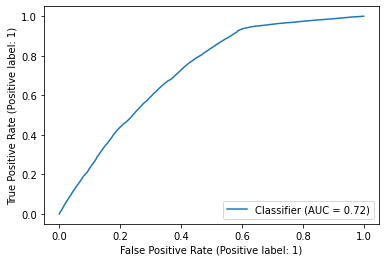

In [36]:
RocCurveDisplay.from_predictions(df[target], y_pred_model3)

In [44]:
np.sqrt(4)

2.0